# Test Glaze et al. model implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

from tasks import GlazeTask
from models import GlazeModel

In [2]:
rng = default_rng(999)

## Create synthetic data

In [3]:
def smp_trials(n_smps, rng, hazard_rate=0.1, noise=0.5, s_init=1):
    
    changes = rng.binomial(1, hazard_rate, n_smps)
    s_right = np.mod(np.cumsum(changes), 2)
    s_smps = s_init * (2 * s_right - 1)
    x_smps = s_smps + rng.normal(0, noise, n_smps)
    
    return s_smps, x_smps

In [4]:
n_trials = 100
h_true = 0.1
x_noise = 1.5

#s_smps, x_smps = smp_trials(n_trials, rng, h_true, x_noise)
task = GlazeTask(h_true, x_noise, rng=rng)
s_smps, x_smps = task.sample_trials(n_trials)

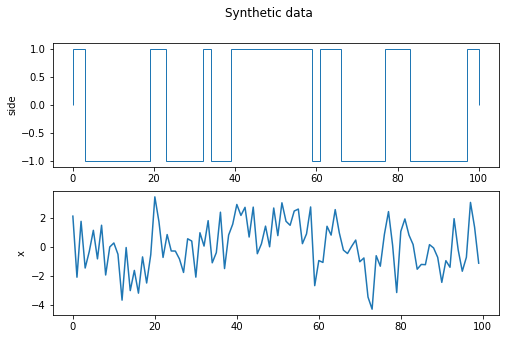

In [5]:
(fig, ax) = plt.subplots(2, 1, figsize=(8, 5))

ax[0].stairs(s_smps)
ax[0].set_ylabel('side')

ax[1].plot(x_smps)
ax[1].set_ylabel('x')

fig.suptitle('Synthetic data');

## Run model with optimal parameters on data

In [6]:
opt_model = GlazeModel()

# Set hazard rate to true value
opt_model.z_hazard = logit(h_true)

# Optimal values for bias and weight
w0_true = 0
w1_true = 2 / (x_noise ** 2)

# Set w_0 and w_1 to true values
opt_model.w_0 = w0_true
opt_model.w_1 = w1_true

# Compute side predictions and log-posterior ratio
r = opt_model.log_posterior_ratio(x_smps)
s_pred = np.sign(r)

# Compute error from predictions
s_err = (s_smps - s_pred) ** 2

### Filter results

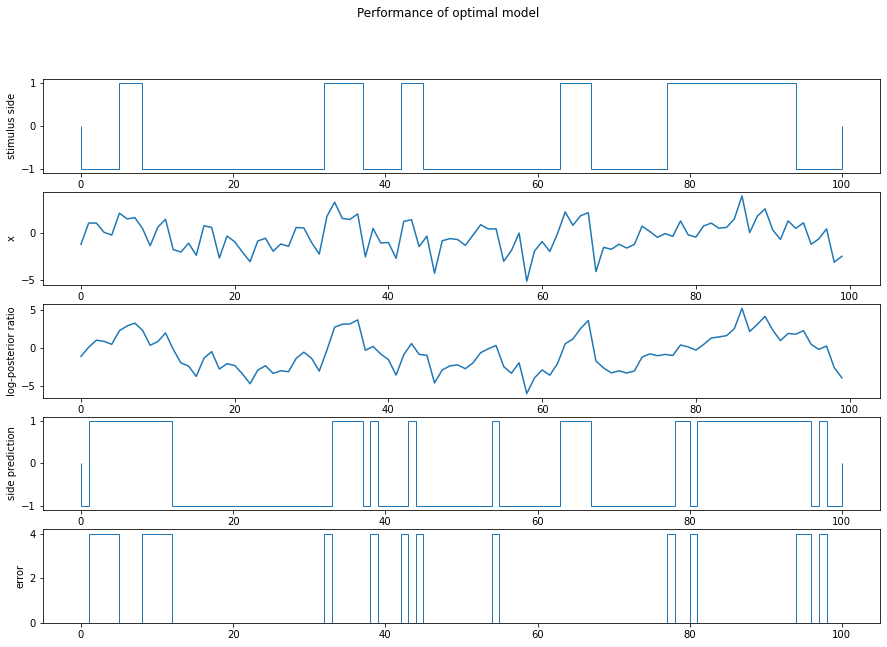

In [7]:
(fig, ax) = plt.subplots(5, 1, figsize=(15, 10))

ax[0].stairs(s_smps)
ax[0].set_ylabel('stimulus side')

ax[1].plot(x_smps)
ax[1].set_ylabel('x')

ax[2].plot(r)
ax[2].set_ylabel('log-posterior ratio')

ax[3].stairs(s_pred)
ax[3].set_ylabel('side prediction')

ax[4].stairs(s_err)
ax[4].set_ylabel('error')

fig.suptitle('Performance of optimal model');

## Recover model parameters from prediction data

In [12]:
# Parameters
n_trials = 100000
x_noise = 0.25
h_true = 0.1
w0_true = 0
w1_true = 2 / (x_noise ** 2)

# Sample data
s_smps, x_smps = smp_trials(n_trials, rng, h_true, x_noise)

In [13]:
# Create model with parameters set to optimal values
opt_model = GlazeModel(rng=rng)
opt_model.z_hazard = logit(h_true)
opt_model.w_0 = w0_true
opt_model.w_1 = w1_true

# Run model on dataset to generate predictions
y = opt_model.sample(x_smps)

In [14]:
# Fit model to preductions from optimal model
fit_model = GlazeModel()
fit_model.fit(x_smps, y)

In [15]:
# Print parameters of fit model
print(f'hazard_rate: {fit_model.hazard_rate} (opt: {h_true})')
print(f'w_0: {fit_model.w_0} (opt: {w0_true})')
print(f'w_1: {fit_model.w_1} (opt: {w1_true})')

hazard_rate: 0.40831910556825923 (opt: 0.1)
w_0: 1.9768974633516747 (opt: 0)
w_1: 1.9621874095304164 (opt: 32.0)
